# 12章 カスタムデータによる画像認識

In [1]:
# 必要ライブラリ・コマンドの導入

!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
w = !apt install tree
print(w[-2])

In [2]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

In [3]:
# PyTorch関連ライブラリのインポート

import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

In [4]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

In [84]:
# seedの固定方法検証中
import random
random.seed(123)
torch.manual_seed(123)

In [85]:
# GPUチェック

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### 共通関数の読み込み

In [86]:
# 共通関数のダウンロード
!git clone https://github.com/makaishi2/pythonlibs.git

# 共通関数のロード
from pythonlibs.torch_lib1 import *

# 共通関数の存在チェック
print(README)

fatal: destination path 'pythonlibs' already exists and is not an empty directory.
Common Library for PyTorch
Author: M. Akaishi


## 12.3 データ準備

### サンプルデータのダウンロード・解凍

In [87]:
# サンプルデータのダウンロード
w = !wget -nc https://download.pytorch.org/tutorial/hymenoptera_data.zip

# 結果確認
print(w[-2])

File ‘hymenoptera_data.zip’ already there; not retrieving.


In [90]:
# データ解凍
w = !unzip -o hymenoptera_data.zip

# 結果確認
print(w[-1])

# 解凍ファイルのtree表示
!tree hymenoptera_data

hymenoptera_data
├── train
│   ├── ants
│   │   ├── 0013035.jpg
│   │   ├── 1030023514_aad5c608f9.jpg
│   │   ├── 1095476100_3906d8afde.jpg
│   │   ├── 1099452230_d1949d3250.jpg
│   │   ├── 116570827_e9c126745d.jpg
│   │   ├── 1225872729_6f0856588f.jpg
│   │   ├── 1262877379_64fcada201.jpg
│   │   ├── 1269756697_0bce92cdab.jpg
│   │   ├── 1286984635_5119e80de1.jpg
│   │   ├── 132478121_2a430adea2.jpg
│   │   ├── 1360291657_dc248c5eea.jpg
│   │   ├── 1368913450_e146e2fb6d.jpg
│   │   ├── 1473187633_63ccaacea6.jpg
│   │   ├── 148715752_302c84f5a4.jpg
│   │   ├── 1489674356_09d48dde0a.jpg
│   │   ├── 149244013_c529578289.jpg
│   │   ├── 150801003_3390b73135.jpg
│   │   ├── 150801171_cd86f17ed8.jpg
│   │   ├── 154124431_65460430f2.jpg
│   │   ├── 162603798_40b51f1654.jpg
│   │   ├── 1660097129_384bf54490.jpg
│   │   ├── 167890289_dd5ba923f3.jpg
│   │   ├── 1693954099_46d4c20605.jpg
│   │   ├── 175998972.jpg
│   │   ├── 178538489_bec7649292.jpg
│   │   ├── 1804095607_0341701e1c.jpg
│   │   

### transformの定義

In [91]:
# transformの定義

# 検証データ用 : 正規化のみ実施
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# 訓練データ用: 正規化に追加で反転とRandomErasingを実施
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

### データセットの定義

In [92]:
# ツリーのベースディレクトリ
data_dir = 'hymenoptera_data'

# 訓練データディレクトリと検証データディレクトリの指定
import os
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'val')

# 分類先クラスのリスト作成
classes = ['ants', 'bees']

In [93]:
# DataSetの定義

# 学習用
train_data = datasets.ImageFolder(train_dir, transform=train_transform)

# 検証用
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

In [94]:
# データ件数確認

print(f'訓練データ: {len(train_data)}件')
print(f'検証データ: {len(test_data)}件')

訓練データ: 244件
検証データ: 153件


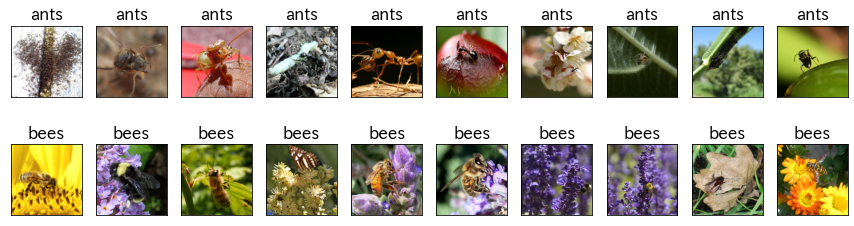

In [95]:
# 検証データ　
# 最初の10個と最後の10個の表示

plt.figure(figsize=(15, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    image, label = test_data[i]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1)/2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 10, i + 11)
    image, label = test_data[-i-1]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1)/2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### DataLoaderの定義

In [96]:
# DataLoaderの定義

batch_size = 10

# 学習用
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)

# 検証用
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# 20個取得 イメージ表示用なのでシャッフルする
test_loader2 = DataLoader(test_data, batch_size=20, shuffle=True, num_workers=0)

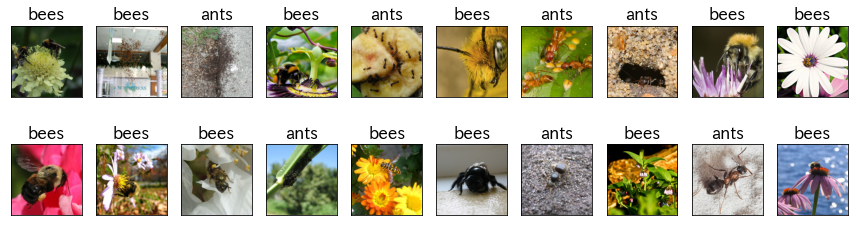

In [97]:
# 最初の20個の表示
for images, labels in test_loader2:
    break

plt.figure(figsize=(15, 4))
for i in range(20):
    ax = plt.subplot(2, 10, i + 1)
    image = images[i]
    label = labels[i]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1)/2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# 最初の20個の表示
for images, labels in test_loader2:
    break

plt.figure(figsize=(15, 4))
for i in range(20):
    ax = plt.subplot(2, 10, i + 1)
    image = images[i]
    label = labels[i]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1)/2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 12.4 ファインチューニング版

In [98]:
# ファインチューニング版

# 学習済みモデルの読み込み
# vgg19_bnを重み付きで読み込む
from torchvision import models
net = models.vgg19_bn(pretrained = True)

# 最終ノードの出力を2に変更する
net.classifier[6] = nn.Linear(4096, 2)

# GPUの利用
net = net.to(device)

# 学習率
lr = 0.001

# 損失関数に交差エントロピーを利用
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=lr,momentum=0.9)

# historyファイルも同時に初期化する
history = np.zeros((0, 5))

In [83]:
# 学習
num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)


Epoch [1/5], loss: 0.04260 acc: 0.79508 val_loss: 0.01378, val_acc: 0.96732



Epoch [2/5], loss: 0.03327 acc: 0.88115 val_loss: 0.01250, val_acc: 0.96078



Epoch [3/5], loss: 0.02984 acc: 0.87705 val_loss: 0.00985, val_acc: 0.96732



Epoch [4/5], loss: 0.01703 acc: 0.93852 val_loss: 0.01823, val_acc: 0.91503



Epoch [5/5], loss: 0.02049 acc: 0.91803 val_loss: 0.01435, val_acc: 0.95425


初期状態: 損失関数: 0.01378 精度: 0.96732
最終状態: 損失関数: 0.01526 精度: 0.93464


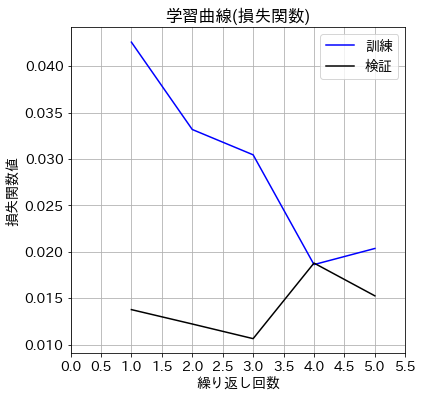

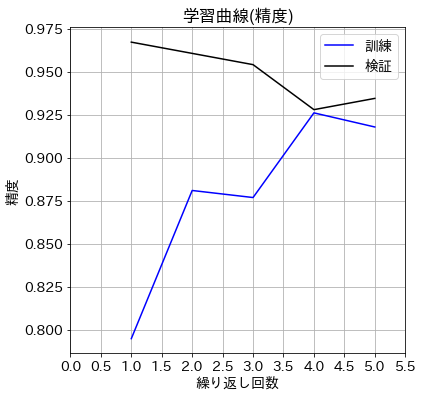

In [21]:
# 結果確認
evaluate_history(history)

## 12.5 転移学習版

In [ ]:
# 学習済みモデルの読み込み
# vgg19_bnを重み付きで読み込む
from torchvision import models
net = models.vgg19_bn(pretrained = True)

# すべてのパラメータで勾配計算なしに
for param in net.parameters():
    param.requires_grad = False

# 最終ノードの出力を2に変更する
# このノードのみ勾配計算をすることになる
net.classifier[6] = nn.Linear(net.classifier[6].in_features, 2)

# GPUの利用
net = net.to(device)

# 学習率
lr = 0.001

# 損失関数に交差エントロピーを利用
criterion = nn.CrossEntropyLoss()

# 最適化関数の定義
# 重み修正の対象を最終ノードに限定
optimizer = optim.SGD(net.classifier[6].parameters(),lr=lr,momentum=0.9)

# historyファイルも同時に初期化する
history = np.zeros((0, 5))

In [ ]:
# 学習
num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)


Epoch [1/5], loss: 0.04880 acc: 0.77869 val_loss: 0.01488, val_acc: 0.95425



Epoch [2/5], loss: 0.02585 acc: 0.89344 val_loss: 0.01220, val_acc: 0.96732



Epoch [3/5], loss: 0.02786 acc: 0.88115 val_loss: 0.01118, val_acc: 0.96732



Epoch [4/5], loss: 0.02430 acc: 0.90164 val_loss: 0.01201, val_acc: 0.96078



Epoch [5/5], loss: 0.02090 acc: 0.90984 val_loss: 0.01094, val_acc: 0.96732


初期状態: 損失関数: 0.01488 精度: 0.95425
最終状態: 損失関数: 0.01094 精度: 0.96732


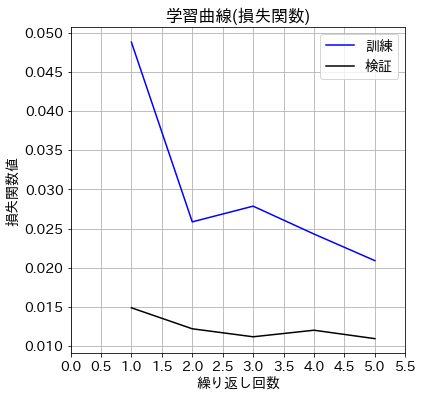

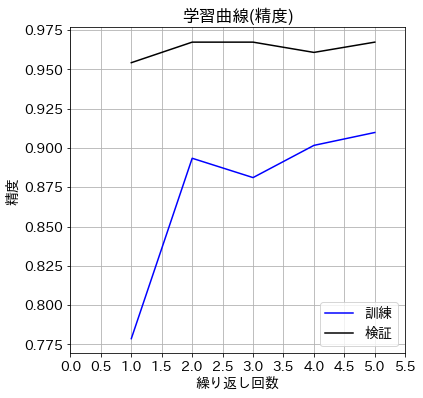

In [ ]:
# 結果サマリー

evaluate_history(history)

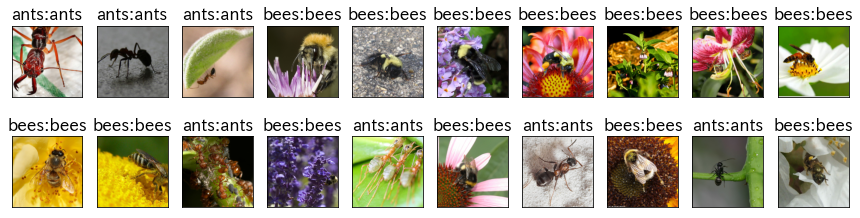

In [ ]:
show_predict_result(net, test_loader2, classes, device)

## 12.6 ユーザー定義データの場合 
シベリアンハスキーとオオカミの画像を利用  
ダウンロード元  
https://pixabay.com/ja/ 

### データダウンロード・解凍

In [ ]:
# データダウンロード
w = !wget https://github.com/makaishi2/pythonlibs/raw/main/images/dog_wolf.zip
print(w[-2])

# 解凍
!unzip dog_wolf.zip | tail -n 1

# 解凍結果のツリー表示
!tree dog_wolf

dog_wolf
├── test
│   ├── dog
│   │   ├── dog1-21.png
│   │   ├── dog1-22.png
│   │   ├── dog1-23.png
│   │   ├── dog1-24.png
│   │   └── dog1-25.png
│   └── wolf
│       ├── wolf21.png
│       ├── wolf22.png
│       ├── wolf23.png
│       ├── wolf24.png
│       └── wolf25.png
└── train
    ├── dog
    │   ├── dog1-01.png
    │   ├── dog1-02.png
    │   ├── dog1-03.png
    │   ├── dog1-04.png
    │   ├── dog1-05.png
    │   ├── dog1-06.png
    │   ├── dog1-07.png
    │   ├── dog1-08.png
    │   ├── dog1-09.png
    │   ├── dog1-10.png
    │   ├── dog1-11.png
    │   ├── dog1-12.png
    │   ├── dog1-13.png
    │   ├── dog1-14.png
    │   ├── dog1-15.png
    │   ├── dog1-16.png
    │   ├── dog1-17.png
    │   ├── dog1-18.png
    │   ├── dog1-19.png
    │   └── dog1-20.png
    └── wolf
        ├── wolf01.png
        ├── wolf02.png
        ├── wolf03.png
        ├── wolf04.png
        ├── wolf05.png
        ├── wolf06.png
        ├── wolf07.png
        ├── wolf08.png
        ├── wolf09.png


### 乱数初期化

In [ ]:
# 乱数初期化　(結果を常に同じにするため)
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### transformの定義

In [ ]:
# transformの定義

# 検証データ用 : 正規化のみ実施
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# 訓練データ用: 正規化に追加で反転とRandomErasingを実施
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)   
])

### データセットの定義

In [ ]:
data_dir = 'dog_wolf'

import os
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

classes = ['dog', 'wolf']

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)


In [ ]:
# データ件数確認

print(f'学習データ: {len(train_data)}件')
print(f'検証データ: {len(test_data)}件')

学習データ: 40件
検証データ: 10件


### データローダーの定義

In [ ]:
batch_size = 5
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
test_loader2 = DataLoader(test_data, batch_size=10, shuffle=False)

In [ ]:
for images, labels in test_loader2:
    break
print(images.shape)

torch.Size([10, 3, 224, 224])


tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])


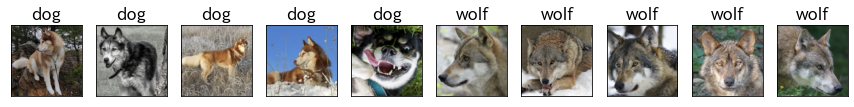

In [ ]:
# 訓練データを取得
for images, labels in test_loader2:
    break

print(labels)

# 最初の10個の表示

plt.figure(figsize=(15, 20))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    image = images[i].numpy()
    label_name = classes[labels[i]]
    img = np.transpose(image, (1, 2, 0))
    img2 = (img + 1)/2 
    plt.imshow(img2)
    ax.set_title(label_name)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### モデルの定義 (転移学習)

In [ ]:
# 学習済みモデルの読み込み
from torchvision import models
net = models.vgg19_bn(pretrained = True)

for param in net.parameters():
    param.requires_grad = False

# 最終ノードの出力を2に変更する
net.classifier[6] = nn.Linear(4096, 2)

# GPUの利用
net = net.to(device)

lr = 0.001
# 損失関数に交差エントロピーを利用
criterion = nn.CrossEntropyLoss()

# 最適化関数の定義
# 重み修正の対象を最終ノードに限定
optimizer = optim.SGD(net.classifier[6].parameters(),lr=lr,momentum=0.9)

# historyファイルも同時に初期化する
history = np.zeros((0, 5))

In [ ]:
# 学習の実行

num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)


Epoch [1/10], loss: 0.13618 acc: 0.57500 val_loss: 0.07146, val_acc: 1.00000



Epoch [2/10], loss: 0.06048 acc: 0.87500 val_loss: 0.04326, val_acc: 0.90000



Epoch [3/10], loss: 0.04522 acc: 0.90000 val_loss: 0.04000, val_acc: 0.90000



Epoch [4/10], loss: 0.03907 acc: 0.92500 val_loss: 0.03482, val_acc: 1.00000



Epoch [5/10], loss: 0.02064 acc: 0.97500 val_loss: 0.02532, val_acc: 1.00000



Epoch [6/10], loss: 0.04891 acc: 0.85000 val_loss: 0.02799, val_acc: 1.00000



Epoch [7/10], loss: 0.03904 acc: 0.92500 val_loss: 0.05187, val_acc: 0.80000



Epoch [8/10], loss: 0.02620 acc: 0.95000 val_loss: 0.03000, val_acc: 1.00000



Epoch [9/10], loss: 0.02752 acc: 0.92500 val_loss: 0.02039, val_acc: 1.00000



Epoch [10/10], loss: 0.00729 acc: 1.00000 val_loss: 0.01967, val_acc: 1.00000


初期状態: 損失関数: 0.07146 精度: 1.00000
最終状態: 損失関数: 0.01967 精度: 1.00000


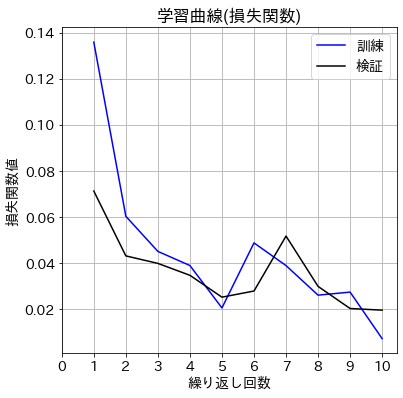

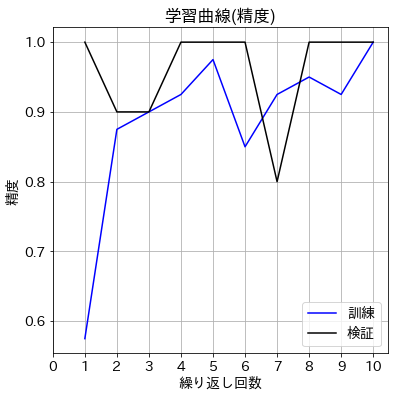

In [ ]:
# 結果サマリー
evaluate_history(history)

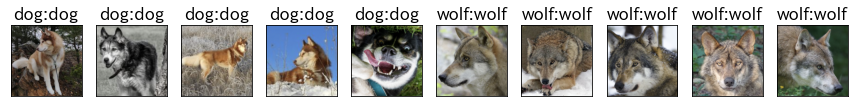

In [ ]:
# 予測結果表示
show_predict_result(net, test_loader2, classes, device)